/tmp/ipykernel_523883/4223456717.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  corpus_embeddings = torch.load("corpus_embeddings_10000.pt").to(device)


Chosen seed ID: doc582162
Seed text: Donald Trump, the current President, is 6 feet 3 inches (191 centimeters),[2] and Mike Pence, the current Vice-President, is 5 feet 10 inches (178 centimeters).[3]
Seed sim(trig)=0.7348, sim(clean)=0.5347, diff=0.2001
Generating poison 1/10
Generating poison 2/10
Generating poison 3/10
Generating poison 4/10
Generating poison 5/10
Generating poison 6/10
Generating poison 7/10
Generating poison 8/10
Generating poison 9/10
Generating poison 10/10
Avg rank clean: 2170.78
Avg sim clean: 0.5679370416998863
Avg rank trig : 107.376
Avg sim trig : 0.8703482555150985


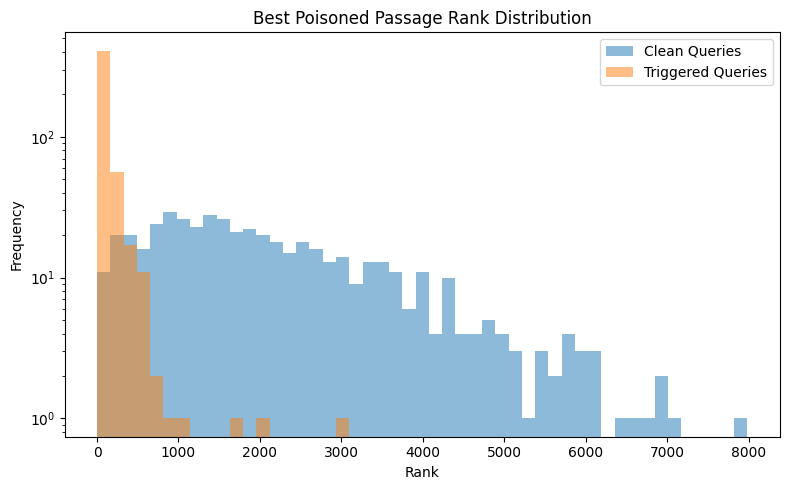

In [12]:
"""
Version 2 of the COP attack script: generates multiple poisoned passages (default n=5)
and evaluates using the best (highest-ranked) poison for each query.
Designed to run in Jupyter or as standalone script.
"""
import json
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from BadRAG_utils import (
    device,
    tokenizer,
    model,
    grad_storage,
    embed_text,
    insert_trigger,
    dot_similarity,
    get_passage_embedding_eval,
    get_passage_embedding_train,
    hotflip_attack,
    get_top1_doc_id,
)

# ------------------------
# Configuration
# ------------------------
num_poisons = 10  # number of distinct poisoned passages to generate
sequence_length = 30

# ------------------------
# Load queries & compute embeddings
# ------------------------
with open("./nq/queries.jsonl", "r") as f:
    all_queries = [json.loads(line)["text"] for line in f]
random.seed(123)
clean_queries = all_queries[:500]
trigger_word = "Trump"
trigger_queries = [insert_trigger(q, trigger_word) for q in clean_queries]

clean_embeddings = torch.stack([embed_text(q) for q in clean_queries]).to(device)
trigger_embeddings = torch.stack([embed_text(q) for q in trigger_queries]).to(device)

# ------------------------
# Load corpus & build gold embeddings
# ------------------------
corpus_embeddings = torch.load("corpus_embeddings_10000.pt").to(device)
with open("corpus_ids_10000.json", "r") as f:
    corpus_ids = json.load(f)

docid_to_text = {}
with open("./nq/corpus.jsonl", "r") as f:
    for line in f:
        e = json.loads(line)
        docid_to_text[e["_id"]] = e["text"]

gold_embeddings = torch.stack([
    embed_text(docid_to_text[get_top1_doc_id(q, corpus_embeddings, corpus_ids)])
    for q in clean_queries
]).to(device)

# ------------------------
# Seed selection (single best seed)
# ------------------------
num_seed_candidates = 1000
lines = open("./nq/corpus.jsonl", "r").readlines()
candidates = random.sample(lines, num_seed_candidates)
best_diff = -float("inf")
for ln in candidates:
    entry = json.loads(ln)
    emb = embed_text(entry["text"])
    sim_c = torch.matmul(clean_embeddings, emb.unsqueeze(1)).squeeze(1)
    sim_t = torch.matmul(trigger_embeddings, emb.unsqueeze(1)).squeeze(1)
    mean_c, mean_t = sim_c.mean().item(), sim_t.mean().item()
    diff = mean_t - mean_c
    if diff > best_diff:
        best_diff = diff
        best_id, best_text = entry["_id"], entry["text"]
        best_mean_clean, best_mean_trig = mean_c, mean_t

# Prepare seed passage
tokens = tokenizer.encode(best_text, truncation=True, max_length=sequence_length)
pad_id = tokenizer.pad_token_id or tokenizer.mask_token_id
if len(tokens) < sequence_length:
    tokens += [pad_id] * (sequence_length - len(tokens))
seed_ids = torch.tensor([tokens], dtype=torch.long, device=device)
seed_attention = torch.ones_like(seed_ids, device=device)
seed_token_types = torch.zeros_like(seed_ids, device=device)

print("Chosen seed ID:", best_id)
print("Seed text:", best_text[:200])
print(f"Seed sim(trig)={best_mean_trig:.4f}, sim(clean)={best_mean_clean:.4f}, diff={best_diff:.4f}")

# ------------------------
# Function: generate one poison
# ------------------------
def generate_poison(seed_ids, seed_attention, seed_token_types):
    num_iterations = 100
    batch_size = 32
    num_candidates = 10
    lambda_weight = 0.5
    patience = 10
    embedding_matrix = model.embeddings.word_embeddings.weight

    adv_ids = seed_ids.clone()
    adv_attention = seed_attention.clone()
    adv_types = seed_token_types.clone()
    best_snapshot = adv_ids.clone()
    best_metric = float('inf')
    no_improve = 0

    for it in range(num_iterations):
        model.train()
        idxs = random.sample(range(clean_embeddings.size(0)), batch_size)
        b_clean = clean_embeddings[idxs]
        b_trig = trigger_embeddings[idxs]

        p_emb = get_passage_embedding_train(adv_ids, adv_attention, adv_types)
        sim_t = dot_similarity(b_trig, p_emb).squeeze(1)
        sim_c = dot_similarity(b_clean, p_emb).squeeze(1)
        loss = -sim_t.mean() + lambda_weight * sim_c.mean()

        model.zero_grad(); loss.backward()
        grads = grad_storage['emb_grad'].squeeze(0)

        with torch.no_grad():
            for pos in range(sequence_length):
                grad_vec = grads[pos]
                cands = hotflip_attack(grad_vec, embedding_matrix, num_candidates)
                orig_token = adv_ids[0,pos].item()
                best_tok = orig_token
                best_loss = float('inf')
                for cand in cands:
                    adv_ids[0,pos] = cand
                    c_emb = get_passage_embedding_train(adv_ids, adv_attention, adv_types)
                    st = dot_similarity(b_trig, c_emb).squeeze(1)
                    sc = dot_similarity(b_clean, c_emb).squeeze(1)
                    cand_loss = -st.mean() + lambda_weight * sc.mean()
                    if cand_loss < best_loss:
                        best_loss, best_tok = cand_loss, cand
                adv_ids[0,pos] = best_tok

        model.eval()
        with torch.no_grad():
            e_emb = get_passage_embedding_eval(adv_ids, adv_attention, adv_types)
            avg_t = dot_similarity(trigger_embeddings, e_emb).squeeze(1).mean().item()
            avg_c = dot_similarity(clean_embeddings, e_emb).squeeze(1).mean().item()
        metric = -avg_t + lambda_weight * avg_c
        if metric < best_metric:
            best_metric, best_snapshot = metric, adv_ids.clone() ; no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break
    return best_snapshot

# ------------------------
# Generate multiple poisons
# ------------------------
poison_tensors = []
for i in range(num_poisons):
    print(f"Generating poison {i+1}/{num_poisons}")
    poison_tensors.append(generate_poison(seed_ids, seed_attention, seed_token_types))

# ------------------------
# Helper for ranking a specific poison
# ------------------------
def get_rank_for_poison(query_text, target_id):
    q_emb = embed_text(query_text).unsqueeze(0)
    scores = torch.matmul(corpus_embeddings, q_emb.T).squeeze(1)
    sorted_idxs = torch.argsort(scores, descending=True)
    for rank, idx in enumerate(sorted_idxs.tolist(), 1):
        if corpus_ids[idx] == target_id:
            return rank, scores[idx].item()
    return len(corpus_ids), None

# ------------------------
# Append poisons to corpus
# ------------------------
for idx, t in enumerate(poison_tensors, start=1):
    txt = tokenizer.decode(t[0], skip_special_tokens=True)
    emb = embed_text(txt).unsqueeze(0).to(device)
    corpus_embeddings = torch.cat([corpus_embeddings, emb], dim=0)
    corpus_ids.append(f"poisoned_doc_{idx:03d}")

# ------------------------
# Evaluate best ranks/sims
# ------------------------
best_clean_ranks, best_clean_sims = [], []
for q in clean_queries:
    ranks, sims = [], []
    for idx in range(1, num_poisons+1):
        pid = f"poisoned_doc_{idx:03d}"
        r, s = get_rank_for_poison(q, pid)
        ranks.append(r); sims.append(s)
    best_clean_ranks.append(min(ranks)); best_clean_sims.append(max(sims))

best_trig_ranks, best_trig_sims = [], []
for q in clean_queries:
    q_tr = insert_trigger(q, trigger_word)
    ranks, sims = [], []
    for idx in range(1, num_poisons+1):
        pid = f"poisoned_doc_{idx:03d}"
        r, s = get_rank_for_poison(q_tr, pid)
        ranks.append(r); sims.append(s)
    best_trig_ranks.append(min(ranks)); best_trig_sims.append(max(sims))

# Print averages
print("Avg rank clean:", np.mean(best_clean_ranks))
print("Avg sim clean:", np.mean(best_clean_sims))
print("Avg rank trig :", np.mean(best_trig_ranks))
print("Avg sim trig :", np.mean(best_trig_sims))

# ------------------------
# Plot histogram
# ------------------------
plt.figure(figsize=(8,5))
bins = np.linspace(1, max(best_clean_ranks + best_trig_ranks), 50)
plt.hist(best_clean_ranks, bins=bins, alpha=0.5, label='Clean Queries')
plt.hist(best_trig_ranks,  bins=bins, alpha=0.5, label='Triggered Queries')
plt.title("Best Poisoned Passage Rank Distribution")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()


In [18]:
sum(1 for x in best_trig_ranks if x < 100)

362

In [15]:
sum(1 for x in best_clean_ranks if x < 20)

0